In [2]:
import pyodbc
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Étape 1 : Connexion à la base de données
try:
    conn = pyodbc.connect(
        'DRIVER={ODBC Driver 17 for SQL Server};'
        'SERVER=DESKTOP-6NBPH33;'
        'DATABASE=DW_Finance;'
        'UID=rana;'
        'PWD=rana;'
    )
    print("Connexion réussie à la base de données.")
except Exception as e:
    print("Connexion échouée :", e)
    exit()

# Étape 2 : Récupération des données
query = """
SELECT 
    f.Fk_Produit,
    dp.ProductID,
    dp.ProductName,
    f.Price,
    f.Amount,
    f.DiscountOffered,
    f.RecommendedProfitMargin,
    fs.TotalAssets,
    fs.TotalLiabilities,
    fs.Equity,
    fs.Budget,
    fs.ActualExpenses,
    fs.AmountDue,
    fs.AmountPaid,
    fs.BalanceDue
FROM dbo.Fact_Purchase f
JOIN dbo.Dim_Produit dp ON f.Fk_Produit = dp.Pk_Produit
JOIN dbo.Fact_Financial_Situation fs ON f.Fk_Invoices = fs.Fk_Invoices
"""
# Chargement des données
df = pd.read_sql(query, conn)
print("\nDonnées chargées avec succès.")

Connexion réussie à la base de données.


C:\Users\MSI\AppData\Local\Temp\ipykernel_17748\28563175.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)



Données chargées avec succès.


In [3]:
# Étape 3 : Création de la variable cible
df['Profit'] = df['Budget'] - df['ActualExpenses']

In [4]:
# Étape 4 : Préparation des features (X) et de la cible (y)
features = [
    'Price', 'Amount', 'DiscountOffered', 'RecommendedProfitMargin',
    'TotalAssets', 'TotalLiabilities', 'Equity',
    'AmountDue', 'AmountPaid', 'BalanceDue'
]
X = df[features]
y = df['Profit']

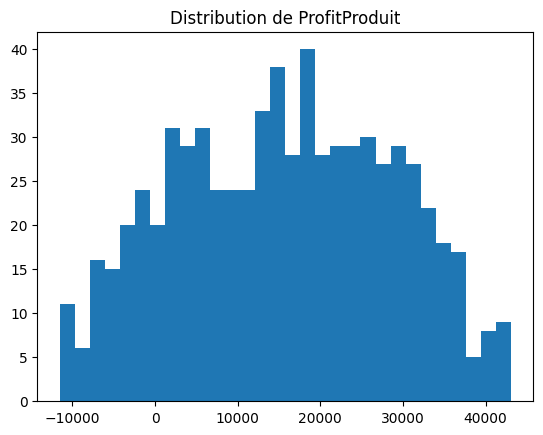

In [5]:
import matplotlib.pyplot as plt

plt.hist(y, bins=30)
plt.title('Distribution de ProfitProduit')
plt.show()


In [6]:
# Étape 5 : Découpage en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# Étape 6 : Entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
# Étape 7 : Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

In [9]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculer MSE, MAE et R²
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Afficher les résultats
print(f"\nMean Squared Error (MSE) : {mse:.2f}")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"R² Score : {r2:.4f}")



Mean Squared Error (MSE) : 191663746.77
Mean Absolute Error (MAE) : 11852.11
R² Score : -0.0041


In [10]:
# Étape 9 : Prédire le profit sur TOUT le dataset
df['PredictedProfit'] = model.predict(X)

In [11]:
# Étape 10 : Recommander le meilleur produit
# On prend celui avec le plus grand profit prédit
best_product = df.loc[df['PredictedProfit'].idxmax()]

print("\nProduit recommandé :")
print(f"ProductID : {best_product['ProductID']}")
print(f"ProductName : {best_product['ProductName']}")
print(f"Profit Prédit : {best_product['PredictedProfit']:.2f}")



Produit recommandé :
ProductID : P100106
ProductName : Carottes Groupe Pomona
Profit Prédit : 17579.90


In [12]:
from xgboost import XGBRegressor
modelxg = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
modelxg.fit(X_train, y_train)

y_pred = modelxg.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error (MSE) : {mse:.2f}")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"R² Score : {r2:.4f}")



Mean Squared Error (MSE) : 202527010.72
Mean Absolute Error (MAE) : 12036.55
R² Score : -0.0611


In [13]:
import numpy as np

# Fonction pour ajouter du bruit aléatoire
def add_noise(df, features, noise_factor=0.05):
    for feature in features:
        noise = np.random.normal(0, noise_factor, df[feature].shape)
        df[feature] += noise
    return df

# Appliquer du bruit sur certaines caractéristiques
features_to_augment = ['Price', 'Amount', 'DiscountOffered', 'RecommendedProfitMargin', 'TotalAssets', 'TotalLiabilities', 'Equity', 'Budget', 'ActualExpenses']
df_augmented = add_noise(df.copy(), features_to_augment, noise_factor=0.02)


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0.8, 1.2))  # Changer les valeurs dans une plage spécifique
scaled_data = scaler.fit_transform(df[['Price', 'Amount', 'DiscountOffered']])

# Ajouter les nouvelles données augmentées dans le dataframe original
df_augmented_scaled = df.copy()
df_augmented_scaled[['Price', 'Amount', 'DiscountOffered']] = scaled_data


In [15]:
from sklearn.utils import resample

# Échantillonnage aléatoire avec remise pour augmenter les données
df_augmented_resampled = resample(df, n_samples=2*len(df), random_state=42)


In [16]:
def interpolate_between_samples(df, n_interpolations=5):
    # Sélectionner uniquement les colonnes numériques
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    new_samples = []
    for i in range(len(df) - 1):
        for _ in range(n_interpolations):
            # Interpolation linéaire entre l'exemple i et l'exemple i+1 sur les colonnes numériques
            alpha = np.random.uniform(0, 1)  # Proportion aléatoire entre 0 et 1
            new_sample = df.iloc[i][numeric_columns] + alpha * (df.iloc[i+1][numeric_columns] - df.iloc[i][numeric_columns])
            new_samples.append(new_sample)
    
    return pd.DataFrame(new_samples)

df_augmented_interpolated = interpolate_between_samples(df)


In [17]:
# Appliquer une combinaison des techniques précédentes
df_augmented_combined = add_noise(df, features_to_augment, noise_factor=0.02)
df_augmented_combined[['Price', 'Amount']] = scaler.fit_transform(df_augmented_combined[['Price', 'Amount']])
df_augmented_combined_resampled = resample(df_augmented_combined, n_samples=2*len(df), random_state=42)


In [18]:
# Step 1: Define your target variable (Profit) and features (X)
df_augmented_interpolated['Profit'] = df_augmented_interpolated['Budget'] - df_augmented_interpolated['ActualExpenses']  # Calculate Profit

# Step 2: Define features (X) and target (y)
X = df_augmented_interpolated[['Price', 'Amount', 'DiscountOffered', 'RecommendedProfitMargin', 'TotalAssets', 'TotalLiabilities', 'Equity', 'AmountDue', 'AmountPaid', 'BalanceDue']]  # Your features
y = df_augmented_interpolated['Profit']  # Target: Profit


In [19]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
import xgboost as xgb

# Create and train the XGBoost model
modelaug = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
modelaug.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_pred = modelaug.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 90662468.33942719
Mean Absolute Error (MAE): 7377.473651593176
R² Score: 0.23513296302257713


In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Step 1: Load or prepare your data (using df as the dataset)
# Assuming df is your dataset with features in X and target in y
X = df[['Price', 'Amount', 'DiscountOffered', 'RecommendedProfitMargin', 'TotalAssets', 'TotalLiabilities', 'Equity', 'AmountDue', 'AmountPaid', 'BalanceDue']]  # Replace with actual feature columns
y = df['Profit']  # Replace with your target column

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Step 4: Define the hyperparameters to tune using RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0]
}

# Step 5: Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,  # Number of different hyperparameter combinations to try
    scoring='neg_mean_squared_error',  # You can choose other metrics like r2_score
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Step 6: Fit the model to the training data
random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
modelfine = random_search.best_estimator_

# Step 7: Predict on the test set using the best model
y_pred = modelfine.predict(X_test)

# Step 8: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits


OSError: [WinError 1450] Ressources système insuffisantes pour terminer le service demandé

In [62]:
# Make sure X has the same number of rows as df
X = df[['Price', 'Amount', 'DiscountOffered', 'RecommendedProfitMargin', 'TotalAssets', 'TotalLiabilities', 'Equity', 'AmountDue', 'AmountPaid', 'BalanceDue']]


In [63]:
# Predict the profit on the entire dataset
predictions = modelaug.predict(X)

# Ensure the number of predictions matches the number of rows in df
if len(predictions) == len(df):
    df['PredictedProfit'] = predictions
else:
    print(f"Error: Mismatch in number of rows - Predictions: {len(predictions)}, DataFrame: {len(df)}")


In [64]:
# Reset the index to ensure alignment
df = df.reset_index(drop=True)
X = X.reset_index(drop=True)

# Now proceed with prediction and assignment
df['PredictedProfit'] = modelaug.predict(X)


In [65]:
# Step 10: Recommend the best product based on predicted profit
best_product = df.loc[df['PredictedProfit'].idxmax()]

print("\nProduit recommandé :")
print(f"ProductID : {best_product['ProductID']}")
print(f"ProductName : {best_product['ProductName']}")
print(f"Profit Prédit : {best_product['PredictedProfit']:.2f}")



Produit recommandé :
ProductID : P100106
ProductName : Carottes Groupe Pomona
Profit Prédit : 39522.36


In [1]:
from IPython.display import FileLink

# Lien pour télécharger
FileLink("mon_modele.pkl")


c:\Users\MSI\Desktop\pi\mon_modele.pkl